# Part 2 This notebook contains the part of k-means clustering.

#### Clustering can divide MSOAs into different categories according to the correlations between different independent variables. Then, the results can intuitively reflect significant differences for the various predictors between MSOAs.

## 1.Load and clean data

In [1]:
# Firstly. import packages that will be used in this study
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import random
random.seed(42)   
np.random.seed(42)

In [2]:
# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.8f}'.format(x))

In [3]:
# define the way of standardization 
mms = MinMaxScaler(feature_range=(-1,1))

In [4]:
# Set Up Functions for Plotting
def plt_ldn(b):
    fig, ax = plt.subplots(1, figsize=(14, 12))
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

In [5]:
# Load Water GeoPackage
w_path = os.path.join('shp','Water.gpkg')
water = gpd.read_file(w_path)

# Boroughs GeoPackage
b_path = os.path.join('shp','Boroughs.gpkg')
boroughs = gpd.read_file(b_path)

In [6]:
msoas = gpd.read_file(os.path.join('shp','London_MSOAs.gpkg'), driver='GPKG')
msoas = msoas.drop(columns=['OBJECTID','MSOA11NM','BNG_E','BNG_N','Borough','msoa11hclnm'])

In [7]:
data = pd.read_csv("coef_violent.csv")
data.rename(columns = {'mso_acode':'MSOAcode'},inplace=True)

In [8]:
data.head()

,MSOAcode,coef_pop_density,coef_age16_29_percent,coef_bame_percent,coef_householdspaces_no_usualresidents,coef_house_price,coef_employment_deprivation,coef_education_skills_deprivation,coef_living_environment_deprivation
0,E02000001,-0.00132034,0.00996059,0.00370938,-0.11019808,0.35834402,2.59047520,-0.00041421,0.01225227
1,E02000002,-0.00058084,0.01213176,-0.00074509,0.18591426,-0.54970102,2.41220497,-0.00384029,0.00751591
2,E02000003,-0.00059427,0.01282855,-0.00072203,0.19973580,-0.56365568,2.37778708,-0.00396551,0.00758584
3,E02000004,-0.00066195,0.01183344,-0.00075466,0.20351523,-0.52420772,2.54068282,-0.00428504,0.00800166
4,E02000005,-0.00061964,0.01242919,-0.00064459,0.19622695,-0.54941483,2.41214781,-0.00425315,0.00774679


In [9]:
# Drop the coefficients we do not want to cluster
data = data.drop(columns=['coef_bame_percent','coef_householdspaces_no_usualresidents','coef_education_skills_deprivation','coef_house_price'])

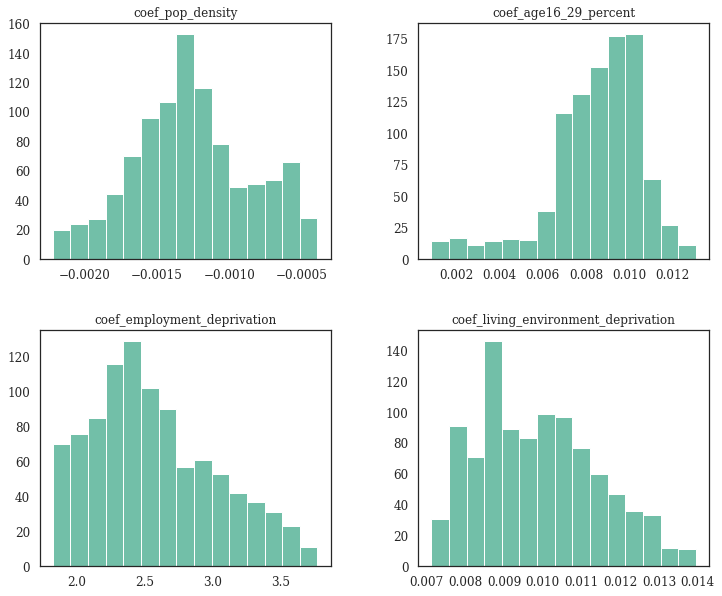

In [10]:
# Seaborn font size and style of plot
sns.set( font_scale = 1, style = 'white' )

# Matplotlib font type
plt.rc('font', family='serif')

data.iloc[:].hist( figsize=(12,10), bins=15,
                   xlabelsize = 12, ylabelsize = 12,
                   color = '#72BFA8',
                   grid = False)
plt.show()

In [11]:
# convert dataframe to geodataframe
data = pd.merge(msoas, data, left_on='MSOA11CD', right_on='MSOAcode', how='inner')

In [12]:
coef = data.drop(columns=['geometry','MSOAcode'])

In [13]:
coef = coef.fillna(0).set_index('MSOA11CD')

### 1.1 Data Standardization

In [14]:
# Rescale the columns using the MinMaxScaler method
for c in coef.columns:
    coef[c] = mms.fit_transform(coef[c].values.reshape(-1,1))

In [15]:
# Create an dataframe to hold the clustering results 
coef_clus = pd.merge(msoas, coef, left_on='MSOA11CD', right_index=True).set_index('MSOA11CD')

In [16]:
coef_clus.head()

,geometry,coef_pop_density,coef_age16_29_percent,coef_employment_deprivation,coef_living_environment_deprivation
MSOA11CD,,,,,
E02000001,"POLYGON ((532135.138 182198.131, 532158.250 18...",-0.01572159,0.49034393,-0.21376906,0.50241694
E02000002,"POLYGON ((548881.563 190845.265, 548881.125 19...",0.79369243,0.84511328,-0.39764981,-0.88532789
E02000003,"POLYGON ((549102.438 189324.625, 548954.517 18...",0.77899480,0.95896915,-0.43315090,-0.86483766
E02000004,"POLYGON ((551550.056 187364.705, 551478.000 18...",0.70491557,0.79636751,-0.26512851,-0.74300438
E02000005,"POLYGON ((549099.634 187656.076, 549161.375 18...",0.75123151,0.89371232,-0.39770877,-0.81767933


## 2.Determination of the Number of Clusters K
### 2.1 The elbow method

In [17]:
# Create a list for the wcss parameter
wcss = []

# Test with 15 clusters
for i in range(1, 16):
    kmeans = KMeans(n_clusters = i, n_init=25, init = 'k-means++', random_state = 42)
    kmeans.fit(coef)
    wcss.append(kmeans.inertia_)
wcss

[734.0378443420357,
 480.10098537789486,
 320.1001151014142,
 241.61604547869834,
 191.33591606563434,
 159.43346714467242,
 140.48488888415102,
 128.05616149582062,
 116.31528963144542,
 106.97024976459133,
 99.08119938003784,
 92.87658694056606,
 88.0439639032762,
 83.60705498985526,
 79.57108192290752]

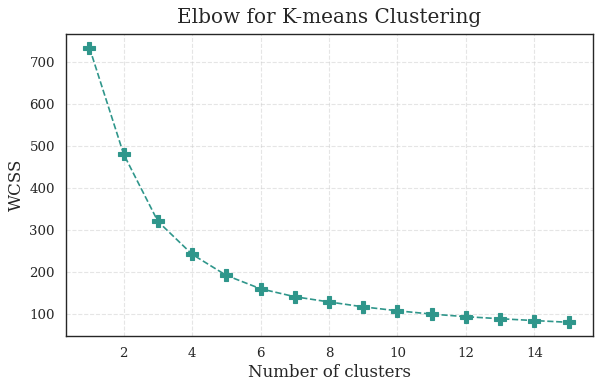

<Figure size 432x288 with 0 Axes>

In [18]:
# Background in plots
c_background = '#FFFFFF'

# Matplotlib font type and seaborn style
sns.set( style = 'white' )
plt.rc('font', family='serif')

plt.figure( figsize=(8.5,5),
           dpi = 80,
           facecolor=c_background
          )
plt.axes().set_facecolor(c_background)

plt.plot(range(1, 16), wcss,
         linestyle = '--', linewidth = 1.5,
         marker = 'P', markersize = 10,
         color = '#2F968B' ,
         label = 'Elbow for K-means Clustering'
        )

plt.title('Elbow for K-means Clustering', size = 18, pad = 10)
plt.xlabel('Number of clusters', size = 15)
plt.ylabel('WCSS', size = 15)
plt.tick_params( labelsize = 12 )

plt.grid( b = True, linestyle = 'dashed', alpha = 0.5 )

plt.show()
plt.savefig("elbow.png",dpi=300)

### 2.2 The Silhouette Method

In [19]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [23]:
# Calculate the average value of the silhouette score for the k-means model
average_sil = silhouette_score(coef,  kmeans.labels_)
print("Average silhouette Score:", average_sil)

Average silhouette Score: 0.3125231493099549


In [24]:
# Create a list of K-Means models, each element is a KMeans model with a specific number of clusters
kmeans_sil= [KMeans(n_clusters=i,  n_init=25, init='k-means++', random_state=42).fit(coef) for i in range(1,16)]

# Calculate silhouette scores for each model
sil_values = [ silhouette_score(coef, model.labels_, random_state=42)
                    for model in kmeans_sil[1:]
                   ]
# Save the silhouette score in an array
sil_score = np.array( sil_values )
sil_score

array([0.32368965, 0.36072663, 0.36743033, 0.35369461, 0.36230893,
       0.35508579, 0.344857  , 0.33960631, 0.31977546, 0.32599034,
       0.32280313, 0.3137785 , 0.32196145, 0.31252315])

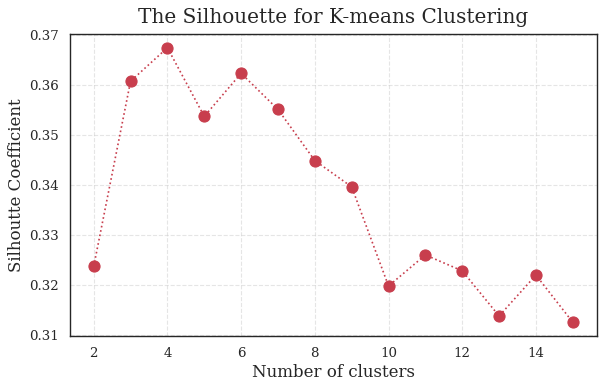

<Figure size 432x288 with 0 Axes>

In [25]:
sns.set( style = 'white' )
plt.rc('font', family='serif')

plt.figure( figsize=(8.5,5),
           dpi = 80,
           facecolor=c_background
          )
plt.axes().set_facecolor = c_background

plt.plot(range(2, 16), sil_score,
         linestyle = ':', linewidth = 1.5,
         marker = 'o', markersize = 10,
         color = '#C83E4D' ,
         label = 'The Silhoutte Method'
        )


plt.title('The Silhouette for K-means Clustering', size = 18, pad = 10)
plt.xlabel('Number of clusters', size = 15)
plt.ylabel('Silhoutte Coefficient', size = 15)
plt.tick_params( labelsize = 12 )

plt.grid( b = True, linestyle = 'dashed', alpha = 0.5 )

plt.show()
plt.savefig("Silhouette.png",dpi=300)

## 3. k-means clustering

#### Comparing the two methods above, the optimal number of clusters is 4 and we apply it to the K-Means algorithm to separate the coefficients into clusters, divide MSOAs into different categories.

In [26]:
clus_nm  = 'KMeans' 

# Add it to the data frame
coef_clus[clus_nm] = pd.Series(kmeans.labels_, index=coef.index)

In [27]:
k = 4
kmeans = KMeans(n_clusters=k, n_init=25, init = 'k-means++', random_state=42).fit(coef)

# Convert to a series
s = pd.Series(kmeans.labels_, index=coef.index, name = clus_nm)
# Add this series to geodatframe for next analysis
coef_clus[clus_nm] = s

In [28]:
s

MSOA11CD
E02000001    2
E02000002    0
E02000003    0
E02000004    0
E02000005    0
            ..
E02006927    0
E02006928    0
E02006929    0
E02006930    0
E02006931    0
Name: KMeans, Length: 983, dtype: int32

In [29]:
# Calculate the overall silhouette score
silhouette_avg = silhouette_score(coef, kmeans.labels_)
silhouette_avg

0.3674303264920387

In [30]:
# Calculate the silhouette values
silhouette_sample = silhouette_samples(coef, kmeans.labels_)

In [31]:
coef_clus.head()

,geometry,coef_pop_density,coef_age16_29_percent,coef_employment_deprivation,coef_living_environment_deprivation,KMeans
MSOA11CD,,,,,,
E02000001,"POLYGON ((532135.138 182198.131, 532158.250 18...",-0.01572159,0.49034393,-0.21376906,0.50241694,2
E02000002,"POLYGON ((548881.563 190845.265, 548881.125 19...",0.79369243,0.84511328,-0.39764981,-0.88532789,0
E02000003,"POLYGON ((549102.438 189324.625, 548954.517 18...",0.77899480,0.95896915,-0.43315090,-0.86483766,0
E02000004,"POLYGON ((551550.056 187364.705, 551478.000 18...",0.70491557,0.79636751,-0.26512851,-0.74300438,0
E02000005,"POLYGON ((549099.634 187656.076, 549161.375 18...",0.75123151,0.89371232,-0.39770877,-0.81767933,0


In [32]:
# Group data by cluster label(--KMeans--) and count observations
kMeans_count = coef_clus.groupby('KMeans').size()
kMeans_count

KMeans
0    339
1    116
2    225
3    303
dtype: int64

In [33]:
# we want to see the coefficients differences among the different clusters,therefore,
# we can compute the unscaled means of each of the parameters in each cluster.
coef_unscaled = pd.read_csv("coef_violent.csv")
coef_unscaled.head()

,mso_acode,coef_pop_density,coef_age16_29_percent,coef_bame_percent,coef_householdspaces_no_usualresidents,coef_house_price,coef_employment_deprivation,coef_education_skills_deprivation,coef_living_environment_deprivation
0,E02000001,-0.00132034,0.00996059,0.00370938,-0.11019808,0.35834402,2.59047520,-0.00041421,0.01225227
1,E02000002,-0.00058084,0.01213176,-0.00074509,0.18591426,-0.54970102,2.41220497,-0.00384029,0.00751591
2,E02000003,-0.00059427,0.01282855,-0.00072203,0.19973580,-0.56365568,2.37778708,-0.00396551,0.00758584
3,E02000004,-0.00066195,0.01183344,-0.00075466,0.20351523,-0.52420772,2.54068282,-0.00428504,0.00800166
4,E02000005,-0.00061964,0.01242919,-0.00064459,0.19622695,-0.54941483,2.41214781,-0.00425315,0.00774679


In [34]:
coef_unscaled = coef_unscaled.drop(columns=['coef_bame_percent','coef_householdspaces_no_usualresidents','coef_education_skills_deprivation','coef_house_price'])

In [35]:
coef_unscaled.rename(columns = {'mso_acode':'MSOAcode','coef_pop_density':'pop_density','coef_age16_29_percent':'age16_29_percent',
                                'coef_employment_deprivation':'employment_deprivation',
                                'coef_living_environment_deprivation':'living_environment_deprivation'},inplace=True)

In [36]:
coef_unscaled = pd.merge(msoas, coef_unscaled, left_on='MSOA11CD', right_on='MSOAcode', how='inner')

In [37]:
coef_unscaled = coef_unscaled.drop(columns=['geometry','MSOAcode'])

In [38]:
# Merge the cluster numbers to the data frame with unscaled parameters
coef_clus_unscaled = pd.merge(coef_unscaled, coef_clus, left_on='MSOA11CD', right_index=True).set_index('MSOA11CD')

In [39]:
coef_clus_unscaled.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 983 entries, E02000001 to E02006931
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   pop_density                          983 non-null    float64 
 1   age16_29_percent                     983 non-null    float64 
 2   employment_deprivation               983 non-null    float64 
 3   living_environment_deprivation       983 non-null    float64 
 4   geometry                             983 non-null    geometry
 5   coef_pop_density                     983 non-null    float64 
 6   coef_age16_29_percent                983 non-null    float64 
 7   coef_employment_deprivation          983 non-null    float64 
 8   coef_living_environment_deprivation  983 non-null    float64 
 9   KMeans                               983 non-null    int32   
dtypes: float64(8), geometry(1), int32(1)
memory usage: 80.6+ KB


In [40]:
# Group table by cluster label, keep the variables used for clustering, and obtain their mean
kMeans_mean = coef_clus_unscaled.groupby('KMeans')['pop_density','age16_29_percent','employment_deprivation',
                                                  'living_environment_deprivation'].mean()

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
kMeans_mean

,pop_density,age16_29_percent,employment_deprivation,living_environment_deprivation
KMeans,,,,
0,-0.00085934,0.00960834,2.32764855,0.00857171
1,-0.00190541,0.01040710,3.29591951,0.01188283
2,-0.00123548,0.00584803,2.17202838,0.01133050
3,-0.00147483,0.00840176,2.86904250,0.00946904


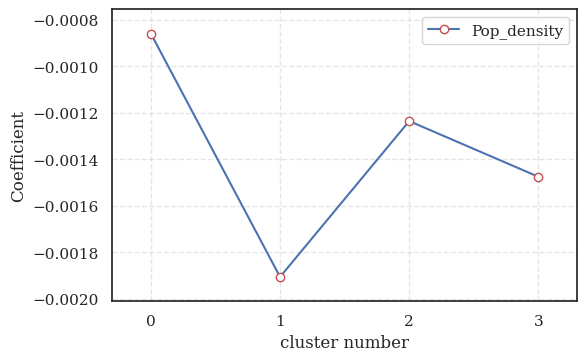

In [49]:
# To visualise the kMeans_mean of four clusters

import matplotlib.pyplot as plt                          

plt.figure( figsize=(6,4),
           dpi = 100,
           facecolor=c_background)

plt.grid( b = True, linestyle = 'dashed', alpha = 0.5 )

names = ['0', '1', '2', '3']

x = range(len(names))
y = kMeans_mean['pop_density']
plt.plot(x, y, marker='o', mec='r', mfc='w',label='Pop_density')
plt.legend()  
plt.xticks(x, names)
plt.margins(0.1)
plt.subplots_adjust(bottom=0.15)
plt.xlabel("cluster number") 
plt.ylabel("Coefficient") 
plt.title("") 

plt.savefig("pop1.png",dpi=300)

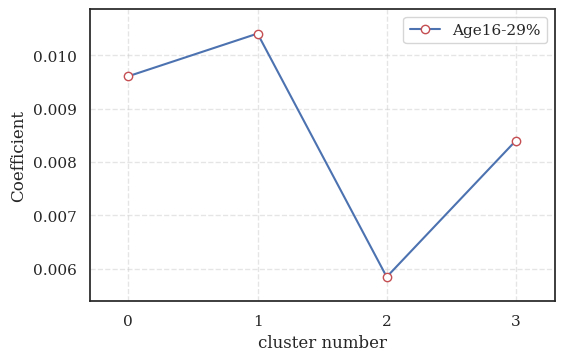

In [50]:
plt.figure( figsize=(6,4),
           dpi = 100,
           facecolor=c_background)

plt.grid( b = True, linestyle = 'dashed', alpha = 0.5 )

names = ['0', '1', '2', '3']

x = range(len(names))
y = kMeans_mean['age16_29_percent']
plt.plot(x, y, marker='o', mec='r', mfc='w',label='Age16-29%')
plt.legend()  
plt.xticks(x, names)
plt.margins(0.1)
plt.subplots_adjust(bottom=0.15)
plt.xlabel("cluster number") 
plt.ylabel("Coefficient") 
plt.title("") 

plt.savefig("age.png",dpi=300)

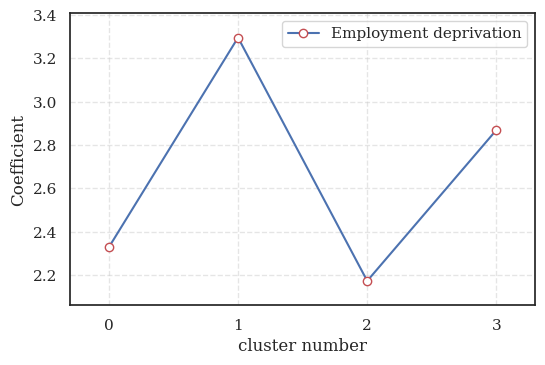

In [51]:
plt.figure( figsize=(6,4),
           dpi = 100,
           facecolor=c_background)

plt.grid( b = True, linestyle = 'dashed', alpha = 0.5 )

names = ['0', '1', '2', '3']

x = range(len(names))
y = kMeans_mean['employment_deprivation']
plt.plot(x, y, marker='o', mec='r', mfc='w',label='Employment deprivation')
plt.legend()  
plt.xticks(x, names)
plt.margins(0.1)
plt.subplots_adjust(bottom=0.15)
plt.xlabel("cluster number") 
plt.ylabel("Coefficient") 
plt.title("") 

plt.savefig("employ.png",dpi=300)

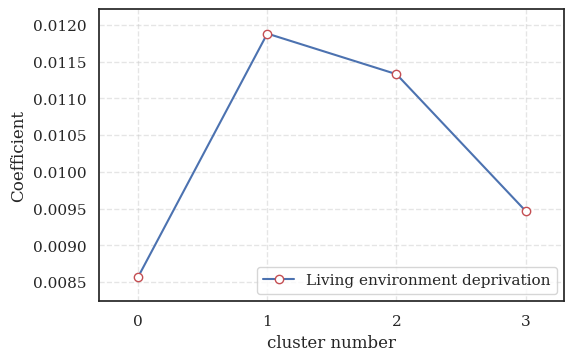

In [52]:
plt.figure( figsize=(6,4),
           dpi = 100,
           facecolor=c_background)

plt.grid( b = True, linestyle = 'dashed', alpha = 0.5 )

names = ['0', '1', '2', '3']

x = range(len(names))
y = kMeans_mean['living_environment_deprivation']
plt.plot(x, y, marker='o', mec='r', mfc='w',label='Living environment deprivation')
plt.legend()  
plt.xticks(x, names)
plt.margins(0.1)
plt.subplots_adjust(bottom=0.15)
plt.xlabel("cluster number") 
plt.ylabel("Coefficient") 
plt.title("") 

plt.savefig("living.png",dpi=300)

In [ ]:
kMeans_mean.to_csv('kMeans_mean.csv',encoding="utf-8")

#### Draw the distribution of each cluster’s values for each variable to get a better cluster profile.

In [47]:
# Index tidy_coef on cluster number
tidy_coef = coef_clus_unscaled.set_index('KMeans')

In [48]:
# Keep only variables used for clustering
tidy_coef = tidy_coef[['pop_density','age16_29_percent','employment_deprivation',
                     'living_environment_deprivation']]

In [49]:
## Referenced from https://geographicdata.science/book/notebooks/

# Stack column names into a column, obtaining a "long" version of the dataset
tidy_coef = tidy_coef.stack()
# Take indices into proper columns
tidy_coef = tidy_coef.reset_index()
# Rename column names
tidy_coef = tidy_coef.rename(columns={'level_1':'Parameters', 0:'Values'})
# Check out result
tidy_coef.head(20)

,KMeans,Parameters,Values
0,2,pop_density,-0.00132034
1,2,age16_29_percent,0.00996059
2,2,employment_deprivation,2.59047520
3,2,living_environment_deprivation,0.01225227
4,0,pop_density,-0.00058084
5,0,age16_29_percent,0.01213176
6,0,employment_deprivation,2.41220497
7,0,living_environment_deprivation,0.00751591
8,0,pop_density,-0.00059427
9,0,age16_29_percent,0.01282855


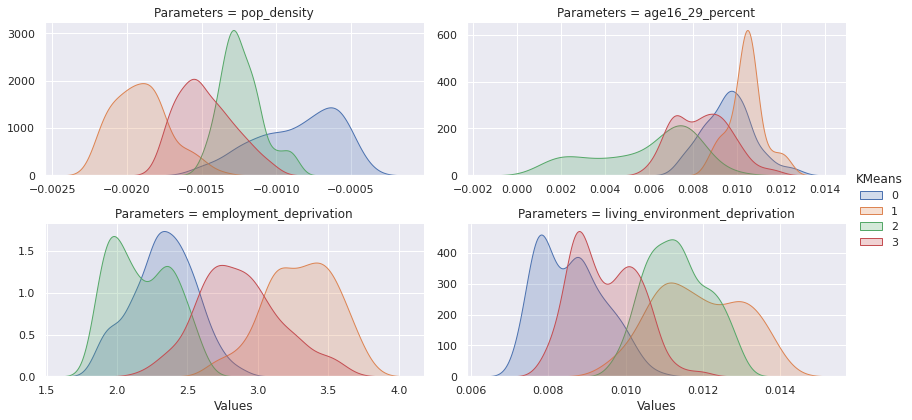

In [50]:
# Scale fonts to make them more readable
sns.set(font_scale = 1)
# Setup the facets
facets = sns.FacetGrid(
    data=tidy_coef,
    col='Parameters',
    hue='KMeans',
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=2
)
# Build the plot from `sns.kdeplot`
_ = facets.map(sns.kdeplot, 'Values', shade=True).add_legend()

plt.savefig("facetgrid.png",dpi=300)

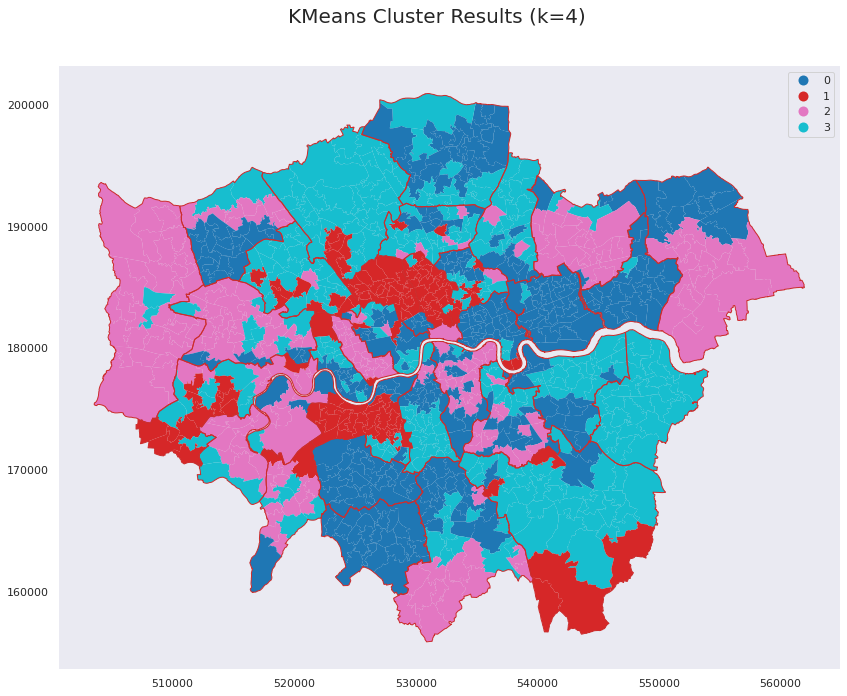

In [65]:
#plot the cluster on the London map
fig, ax = plt_ldn(boroughs)
plt.grid(b = False)
fig.suptitle(f"{clus_nm} Cluster Results (k={k})", fontsize=20, y=0.92)
coef_clus.plot(column=clus_nm, ax=ax, linewidth=0, zorder=0, categorical=True, legend=True);

plt.savefig("Kmeans.png",dpi=300)